<a href="https://colab.research.google.com/github/Mariannly/Quark5-CoAfina2025/blob/main/leer_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "cdsapi>=0.7.7"
!pip install xarray
!pip install cfgrib

In [2]:
import os
import cdsapi
import time
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
cdsapirc_content = """url: https://cds.climate.copernicus.eu/api
key: 01876cbb-e8a2-4cb4-8d98-5f4ba769fc1a
"""

# Crear el archivo de configuración en la ruta esperada
with open(os.path.expanduser("~/.cdsapirc"), "w") as f:
    f.write(cdsapirc_content)

print("✅ Archivo .cdsapirc creado correctamente")


✅ Archivo .cdsapirc creado correctamente


In [4]:
c = cdsapi.Client()
print("✅ Conexión establecida con Copernicus CDS API")

✅ Conexión establecida con Copernicus CDS API


In [5]:
dataset = "reanalysis-era5-land-monthly-means"
bbox_riohacha = {
    "north": 11.80,
    "south": 11.30,
    "west": -73.20,
    "east": -72.60,
}
request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": [
        "total_precipitation",
        "2m_temperature",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "surface_solar_radiation_downwards",
        "evaporation_from_vegetation_transpiration",
        "evaporation_from_bare_soil",
    ],
    "year": [str(y) for y in range(1985, 2025)],   # 1985–2024
    "month": [f"{m:02d}" for m in range(1, 13)],
    "time": "00:00",
    "area": [
        bbox_riohacha["north"],
        bbox_riohacha["west"],
        bbox_riohacha["south"],
        bbox_riohacha["east"],
    ],
    "format": "netcdf",
}

c.retrieve(dataset, request).download()


2025-11-08 00:48:40,360 INFO Request ID is abded6af-0c66-48d2-b5c4-5ca6d11709ec
INFO:ecmwf.datastores.legacy_client:Request ID is abded6af-0c66-48d2-b5c4-5ca6d11709ec
2025-11-08 00:48:40,616 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-08 00:48:55,168 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-11-08 00:49:03,040 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


d10a2162d2759060cd3b0a8c1c25d670.zip:   0%|          | 0.00/319k [00:00<?, ?B/s]

'd10a2162d2759060cd3b0a8c1c25d670.zip'

In [6]:
data_file = 'd10a2162d2759060cd3b0a8c1c25d670.zip'
#umcompress file
!unzip -q {data_file}

replace data_stream-moda.nc? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [7]:
file = "data_stream-moda.nc"

# Open the NetCDF file using xarray
ds = xr.open_dataset(file)

# Display the dataset information
print(ds)

<xarray.Dataset> Size: 576kB
Dimensions:     (valid_time: 480, latitude: 6, longitude: 7)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1985-01-01 ... 2024-12-01
  * latitude    (latitude) float64 48B 11.8 11.7 11.6 11.5 11.4 11.3
  * longitude   (longitude) float64 56B -73.2 -73.1 -73.0 ... -72.8 -72.7 -72.6
    number      int64 8B ...
    expver      (valid_time) <U4 8kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 81kB ...
    t2m         (valid_time, latitude, longitude) float32 81kB ...
    swvl1       (valid_time, latitude, longitude) float32 81kB ...
    swvl2       (valid_time, latitude, longitude) float32 81kB ...
    swvl3       (valid_time, latitude, longitude) float32 81kB ...
    swvl4       (valid_time, latitude, longitude) float32 81kB ...
    ssrd        (valid_time, latitude, longitude) float32 81kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather For

In [12]:
df_ds = ds.to_dataframe()
print(df_ds.head(-1))

                                     tp         t2m     swvl1     swvl2  \
valid_time latitude longitude                                             
1985-01-01 11.8     -73.2           NaN         NaN       NaN       NaN   
                    -73.1           NaN         NaN       NaN       NaN   
                    -73.0           NaN         NaN       NaN       NaN   
                    -72.9           NaN         NaN       NaN       NaN   
                    -72.8           NaN         NaN       NaN       NaN   
...                                 ...         ...       ...       ...   
2024-12-01 11.3     -73.1      0.000720  300.195251  0.242981  0.264847   
                    -73.0      0.000603  300.492126  0.246460  0.280762   
                    -72.9      0.000769  300.289001  0.272339  0.293289   
                    -72.8      0.000930  299.986267  0.277161  0.296539   
                    -72.7      0.001085  299.718689  0.282471  0.293182   

                        

In [19]:
# Extract year from the 'valid_time' level of the MultiIndex
years = df_ds.index.get_level_values('valid_time').year

# Create a new MultiIndex with 'year' as a new level, followed by the original levels
new_index = pd.MultiIndex.from_arrays([years,
                                        df_ds.index.get_level_values('valid_time'),
                                        df_ds.index.get_level_values('latitude'),
                                        df_ds.index.get_level_values('longitude')],
                                       names=['year', 'valid_time', 'latitude', 'longitude'])

# Assign the new MultiIndex to the DataFrame
df_ds.index = new_index

print(df_ds.head())

                                          tp         t2m     swvl1     swvl2  \
year valid_time latitude longitude                                             
1985 1985-01-01 11.7     -72.6      0.000548  298.471313  0.058365  0.124802   
                11.6     -72.8      0.000683  297.869751  0.065475  0.119354   
                         -72.7      0.000676  298.035767  0.065170  0.102692   
                         -72.6      0.000671  298.178345  0.063950  0.103363   
                11.5     -73.0      0.000760  297.510376  0.202545  0.251770   

                                       swvl3     swvl4        ssrd  number  \
year valid_time latitude longitude                                           
1985 1985-01-01 11.7     -72.6      0.189133  0.181259  18721900.0       0   
                11.6     -72.8      0.182281  0.151749  18732024.0       0   
                         -72.7      0.168503  0.128723  18594416.0       0   
                         -72.6      0.170013  0.1

In [17]:
#select and drop all rowa with NaNs
df_ds = df_ds.dropna()
df_ds

tp         t2m     swvl1     swvl2  \
valid_time latitude longitude                                             
1985-01-01 11.7     -72.6      0.000548  298.471313  0.058365  0.124802   
           11.6     -72.8      0.000683  297.869751  0.065475  0.119354   
                    -72.7      0.000676  298.035767  0.065170  0.102692   
                    -72.6      0.000671  298.178345  0.063950  0.103363   
           11.5     -73.0      0.000760  297.510376  0.202545  0.251770   
...                                 ...         ...       ...       ...   
2024-12-01 11.3     -73.0      0.000603  300.492126  0.246460  0.280762   
                    -72.9      0.000769  300.289001  0.272339  0.293289   
                    -72.8      0.000930  299.986267  0.277161  0.296539   
                    -72.7      0.001085  299.718689  0.282471  0.293182   
                    -72.6      0.001566  299.566345  0.306931  0.313736   

                                  swvl3     swvl4        ssrd  number expver  
valid_time latitude longitude                                                 
1985-01-01 11.7     -72.6      0.189133  0.181259  18721900.0       0   0001  
           11.6     -72.8      0.182281  0.151749  18732024.0       0   0001  
                    -72.7      0.168503  0.128723  18594416.0       0   0001  
                    -72.6      0.170013  0.142792  18447588.0       0   0001  
           11.5     -73.0      0.320663  0.338699  18988144.0       0   0001  
...                                 ...       ...         ...     ...    ...  
2024-12-01 11.3     -73.0      0.339874  0.227386  17560744.0       0   0001  
                    -72.9      0.351059  0.283340  17488180.0       0   0001  
                    -72.8      0.351212  0.277542  17412612.0       0   0001  
                    -72.7      0.337723  0.211319  17333444.0       0   0001  
                    -72.6      0.351410  0.246872  17262464.0       0   0001  

[10560 rows x 9 columns]

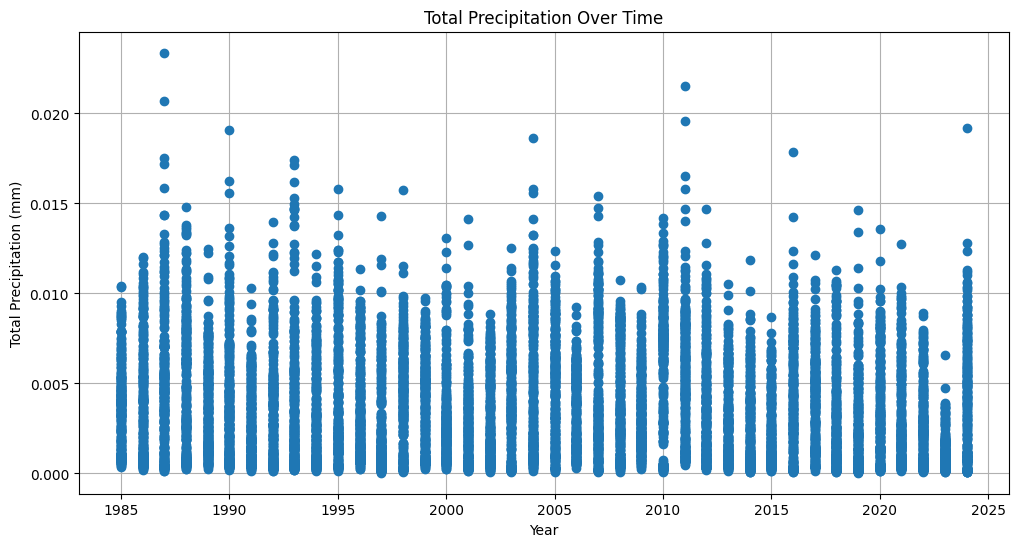

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(years, df_ds['tp'], marker='o', linestyle='')
plt.title('Total Precipitation Over Time')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.show()

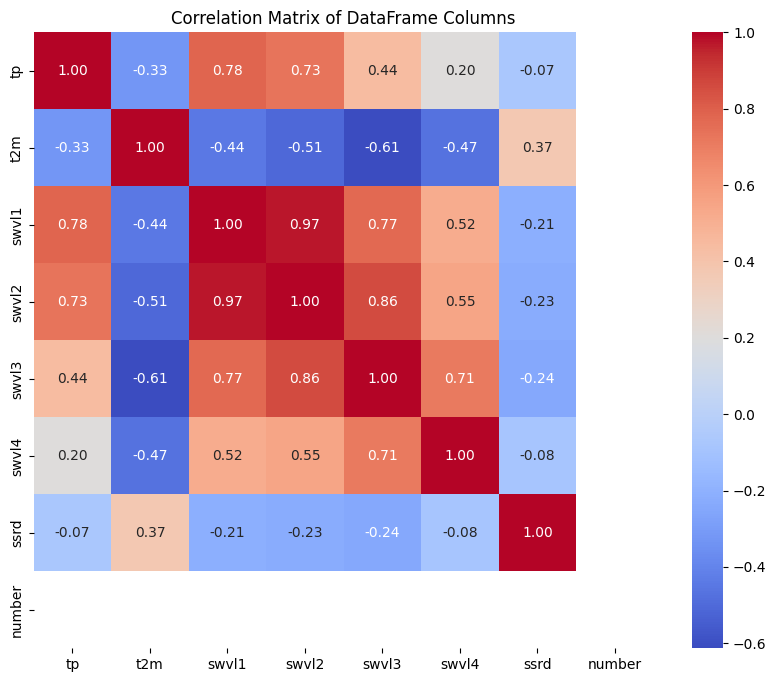

In [21]:
# Calculate the correlation matrix
correlation_matrix = df_ds.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of DataFrame Columns')
plt.show()